# Sensitivity Analysis of SVM using DiffOpt.jl

- This notebook illustrates sensitivity analysis of data points in an SVM. 
- Inspired from http://github.com/matbesancon/SimpleSVMs.jl

For reference, Section 10.1 of https://online.stat.psu.edu/stat508/book/export/html/792 gives an intuitive explanation of what does it means to have a sensitive hyperplane or data point. The SVM is defined as:

$$
\begin{split}
\begin{array} {ll}
\mbox{minimize} & \sum_{i=1}^{N} \xi_{i} \\
\mbox{s.t.} & \xi_{i} \ge 0 \quad i=1..N  \\
            & y_{i} (w^T X_{i} + b) \ge 1 - \xi[i]\\
\end{array}
\end{split}
$$
where
- $X$, $y$ are the N data points
- $\xi$ is soft-margin loss

## Part 1: Define and solve the SVM

In [93]:
import Random
import SCS
import Plots
using DiffOpt
using JuMP
using LinearAlgebra

In [101]:
N = 50
D = 2
X = vcat(randn(N, D), randn(N,D) .+ [4.0,1.5]')
y = append!(ones(N), -ones(N))
N = 2*N;

In [102]:
model = Model(() -> diff_optimizer(SCS.Optimizer))

# add variables
@variable(model, l[1:N])
@variable(model, w[1:D])
@variable(model, b);

In [103]:
@constraint(model, cons, y.*(X*w .+ b) + l.-1 ∈ MOI.Nonnegatives(N))
@constraint(model, 1.0*l ∈ MOI.Nonnegatives(N));

In [104]:
@objective(
    model,
    Min,
    sum(l),
)

optimize!(model)

loss = objective_value(model)
wv = value.(w)
bv = value(b);

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 500, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 103, constraints m = 200
Cones:	linear vars: 200
Setup time: 2.00e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 8.40e+19  3.04e+20  1.00e+00 -5.58e+21  3.33e+21  2.08e+21  1.00e-04 
    60| 2.42e-08  3.44e-08  5.24e-07 -5.24e-07 -0.00e+00  3.08e-15  2.08e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: 

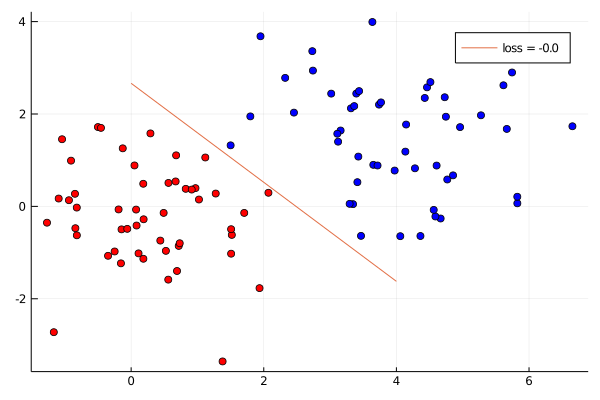

In [105]:
p = Plots.scatter(X[:,1], X[:,2], color = [yi > 0 ? :red : :blue for yi in y], label = "")
Plots.plot!(p, [0.0, 4.0], [-bv / wv[2], (-bv - 4wv[1])/wv[2]], label = "loss = $(round(loss, digits=2))")

## Part 2: Differentiate wrt each data point

## Experiment 1:
Change data point labels `y` without changing data points themselves `X`

In [106]:
∇ = Float64[]
dy = zeros(N)

# begin differentiating
for Xi in 1:N
    dy[Xi] = 1.0  # set
    
    MOI.set(
        model,
        DiffOpt.ForwardIn{DiffOpt.ConstraintCoefficient}(), 
        b, 
        cons, 
        dy
    )
    
    DiffOpt.forward(model)
    
    dw = MOI.get.(
        model,
        DiffOpt.ForwardOut{MOI.VariablePrimal}(), 
        w
    ) 
    db = MOI.get(
        model,
        DiffOpt.ForwardOut{MOI.VariablePrimal}(), 
        b
    ) 
    push!(∇, norm(dw) + norm(db))
    
    dy[Xi] = 0.0  # reset
end
∇ = normalize(∇);

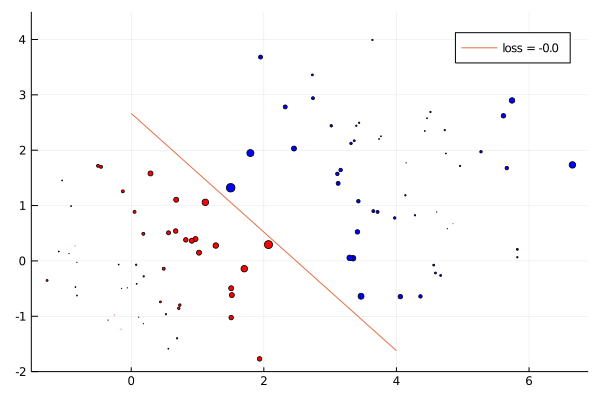

In [107]:
# point sensitvity wrt the separating hyperplane
# gradients are normalized

p2 = Plots.scatter(
    X[:,1], X[:,2], 
    color = [yi > 0 ? :red : :blue for yi in y], label = "",
    markersize = ∇ * 20
)
Plots.yaxis!(p2, (-2, 4.5))
Plots.plot!(p2, [0.0, 4.0], [-bv / wv[2], (-bv - 4wv[1])/wv[2]], label = "loss = $(round(loss, digits=2))")